In [1]:
from import_module import *

/home/youngwon/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [20]:
def conv_block(in_channels,out_channels,kernel_size,stride,padding,dilation=1,relu=True):
    layers = []
    layers += [nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,dilation,bias=False)]
    layers += [nn.BatchNorm2d(out_channels)]
    if relu:
        layers += [nn.ReLU()]
    return nn.Sequential(*layers)

In [21]:
class Bottleneck(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1,dilation=1,downsample=False):
        super().__init__()
        self.block = nn.Sequential(
            conv_block(in_channels,out_channels//4,kernel_size=1,stride=1,padding=0),
            conv_block(out_channels//4,out_channels//4,3,stride,dilation,dilation),
            conv_block(out_channels//4,out_channels,kernel_size=1,stride=1,padding=0,relu=False)
        )
        self.downsample = nn.Sequential(
            conv_block(in_channels,out_channels,kernel_size=1,stride=stride,padding=0,relu=False)
        ) if downsample else None
        
        self.relu=nn.ReLU()
    
    def forward(self,x):
        identity = x
        out = self.block(x)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out
        

In [22]:
class ResBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride,dilation,num_layers):
        super().__init__()
        block = []
        for i in range(num_layers):
            block.append(Bottleneck(
                in_channels if i==0 else out_channels,
                out_channels,
                stride if i==0 else 1,
                dilation,
                True if i==0 else False
            ))
        self.block = nn.Sequential(*block)
    def forward(self,x):
        return self.block(x)
    
        

In [23]:
class ASPP(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.rate6_block = nn.Sequential(
            conv_block(in_channels,in_channels,3,1,padding=6,dilation=6),
            conv_block(in_channels,in_channels,1,1,0),
            conv_block(in_channels,out_channels,1,1,0)
        )
        self.rate12_block = nn.Sequential(
            conv_block(in_channels,in_channels,3,1,padding=12,dilation=12),
            conv_block(in_channels,in_channels,1,1,0),
            conv_block(in_channels,out_channels,1,1,0)
        )
        self.rate18_block = nn.Sequential(
            conv_block(in_channels,in_channels,3,1,padding=18,dilation=18),
            conv_block(in_channels,in_channels,1,1,0),
            conv_block(in_channels,out_channels,1,1,0)
        )
        self.rate24_block = nn.Sequential(
            conv_block(in_channels,in_channels,3,1,padding=24,dilation=24),
            conv_block(in_channels,in_channels,1,1,0),
            conv_block(in_channels,out_channels,1,1,0),
        )
    def forward(self,x):
        out1 = self.rate6_block(x)
        out2 = self.rate12_block(x)
        out3 = self.rate18_block(x)
        out4 = self.rate24_block(x)
        
        return out1+out2+out3+out4
    

In [28]:
from import_module import *
pred = np.load('/mnt/NAS/youngwon/output/checkImg/013_pred.npy')
mask = np.load('/mnt/NAS/youngwon/output/checkImg/013_mask.npy')

In [29]:
pred2 = pred[-1].squeeze()

In [30]:
pred2.shape

(64, 128, 128)

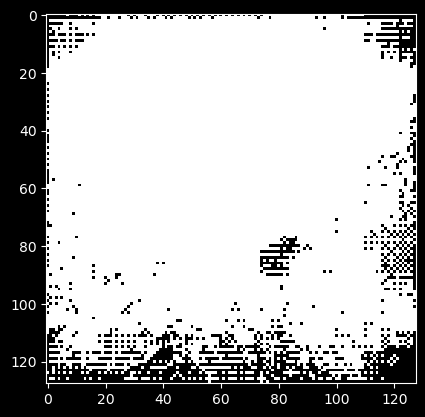

In [31]:
plt.imshow(pred2[0],cmap='gray')

In [25]:
mask2 = mask[-1].squeeze()

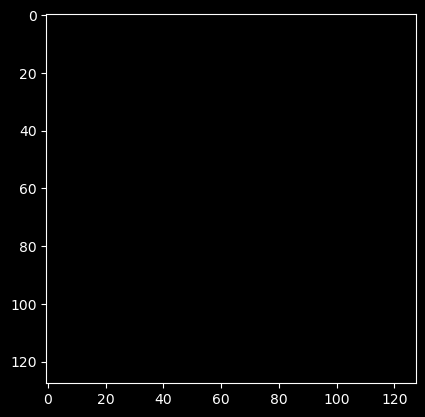

In [26]:
plt.imshow(mask2[0],cmap='gray')